# Modelo de Regressão Logística


### --- 1. Importação das Bibliotecas ---

In [108]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
import numpy as np


### --- 2. Carregamento e Preparação dos Dados ---

In [109]:
# Carrega o arquivo CSV
df = pd.read_csv('Dados Históricos - Ibovespa.csv', dtype=str)

# Converte a coluna 'Data' para o formato de data (datetime)
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')

# Ordena os dados da data mais antiga para a mais recente
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)

# Limpa e converte as colunas numéricas para o formato float
# Remove o ponto de milhar e substitui a vírgula de decimal por ponto
for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpa e converte a coluna 'Var%' (Variação Percentual)
df['Var%'] = df['Var%'].str.replace(',', '.', regex=False).str.replace('%', '', regex=False).astype(float)

### --- 3. Engenharia de Features (Criação de Variáveis) ---

In [110]:
# Cria as colunas com os valores de fechamento ('Último') dos 5 dias anteriores
# Essas serão as informações que o modelo usará para prever
for i in range(1, 6):
    df[f'D-{i}'] = df['Último'].shift(i)

### --- 4. Criação da Variável Alvo ---

In [111]:
# Cria a coluna "Alvo" que o modelo tentará prever
# 1 significa que o Ibovespa fechou em ALTA (variação > 0)
# 0 significa que o Ibovespa fechou em BAIXA ou estável (variação <= 0)
df['Alvo'] = (df['Var%'] > 0).astype(int)

# Remove as primeiras linhas que ficaram com valores nulos após o shift
df_modelo = df.dropna()



### --- 5. Preparação para o Treinamento e Padronização dos Dados ---

In [112]:
# Define quais colunas serão as features (X) e qual será o alvo (y)
features = [f'D-{i}' for i in range(1, 6)]
X = df_modelo[features]
y = df_modelo['Alvo']

# Divide os dados em conjunto de treino e teste
# Usamos 80% para treinar e 20% para testar
# shuffle=False é crucial para dados de série temporal, para que o teste seja feito nos dados mais recentes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 2868 amostras
Tamanho do conjunto de teste: 718 amostras


In [113]:
# Cria o objeto scaler
scaler = StandardScaler()

# Aplica a padronização NOS DADOS DE TREINO E TESTE
# Usamos fit_transform no treino para "aprender" a escala e aplicá-la
X_train_scaled = scaler.fit_transform(X_train)

# Usamos apenas .transform no teste para aplicar a MESMA escala aprendida no treino
X_test_scaled = scaler.transform(X_test)



### --- 6. Treinamento do Modelo de Regressão Logística ---



In [114]:
# Cria a instância do modelo
modelo_logistico = LogisticRegression(random_state=42)

# Treina o modelo com os dados de treino
modelo_logistico.fit(X_train_scaled, y_train)
print("\nModelo treinado com sucesso!")


Modelo treinado com sucesso!




### --- 7. Avaliação do Modelo ---




Acurácia do modelo nos dados de teste: 48.19%


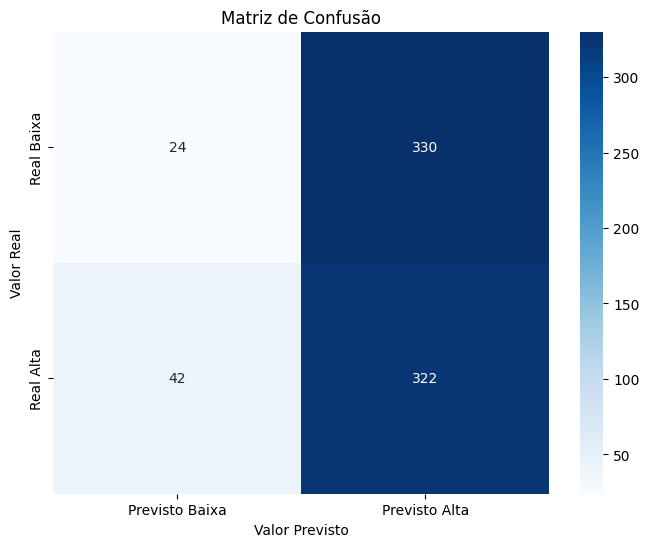

In [115]:
# Faz as previsões com os dados de teste (que o modelo nunca viu)
previsoes = modelo_logistico.predict(X_test_scaled)

# Calcula a acurácia do modelo
acuracia = accuracy_score(y_test, previsoes)

print(f"\nAcurácia do modelo nos dados de teste: {acuracia:.2%}")

# Gera a Matriz de Confusão para uma análise mais detalhada
matriz_confusao = confusion_matrix(y_test, previsoes)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Baixa', 'Previsto Alta'],
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

### --- 8. Otimização de Hiperparâmetros com GridSearchCV ---

In [116]:
# Define os parâmetros que queremos testar
# O Grid Search vai testar todas as combinações possíveis
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Cria uma instância do modelo de Regressão Logística
# Não definimos os parâmetros aqui, pois o Grid Search fará isso
modelo = LogisticRegression(random_state=42, max_iter=5000) # Aumentamos max_iter para evitar erros de convergência

# Cria a instância do GridSearchCV
# cv=5 significa que usaremos validação cruzada com 5 "dobras" (folds)
# n_jobs=-1 usa todos os processadores disponíveis para acelerar o processo
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1 # Mostra o progresso do treinamento
)

# Executa a busca pelos melhores parâmetros usando os dados de treino padronizados
grid_search.fit(X_train_scaled, y_train)

# Mostra os melhores parâmetros encontrados
print("\nMelhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# Mostra a melhor acurácia durante a validação cruzada
print(f"\nMelhor acurácia (cross-validation): {grid_search.best_score_:.2%}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores hiperparâmetros encontrados:
{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Melhor acurácia (cross-validation): 51.67%




### --- 9. Avaliação do Modelo Otimizado ---




Acurácia do modelo OTIMIZADO no conjunto de teste: 48.33%


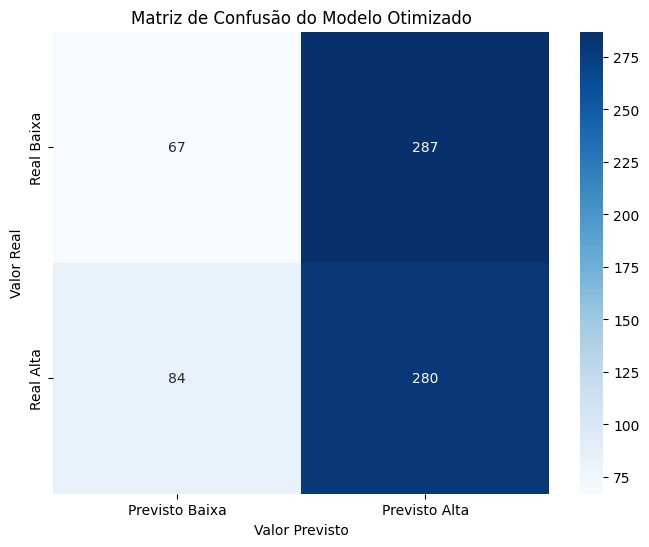

In [117]:
# O `grid_search` já retreina o melhor modelo com todos os dados de treino.
# Podemos usá-lo diretamente para prever nos dados de teste.
best_model = grid_search.best_estimator_

# Faz as previsões com o modelo otimizado
previsoes_otimizadas = best_model.predict(X_test_scaled)

# Calcula a nova acurácia no conjunto de teste
acuracia_otimizada = accuracy_score(y_test, previsoes_otimizadas)

print(f"\nAcurácia do modelo OTIMIZADO no conjunto de teste: {acuracia_otimizada:.2%}")

# Gera a nova Matriz de Confusão
matriz_confusao_otimizada = confusion_matrix(y_test, previsoes_otimizadas)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao_otimizada, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Baixa', 'Previsto Alta'],
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title('Matriz de Confusão do Modelo Otimizado')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

### --- 10. Ajuste Fino do Limiar de Decisão (Threshold) ---

O modelo aprendeu que ele tem mais chances de acertar se ele sempre chutar 'alta' e ai nunca tentou prever uma baixa. Vamos ajustar esse threshold para que ele possa tentar prever baixas com confiança.

In [118]:
# Pega o melhor modelo encontrado pelo GridSearch
best_model = grid_search.best_estimator_

# Em vez de prever a classe (0 ou 1), vamos pegar as PROBABILIDADES
# O resultado será um array com duas colunas: [prob_de_ser_0, prob_de_ser_1]
predicted_probabilities = best_model.predict_proba(X_test_scaled)

# Vamos focar na probabilidade da classe 1 ("Alta")
prob_alta = predicted_probabilities[:, 1]

print("--- Analisando Performance com Diferentes Limiares ---\n")

# Loop para testar os limiares de 0.5 até 0.95, de 0.05 em 0.05
for threshold in np.arange(0.5, 1.0, 0.01):
    print(f"======================================================")
    print(f"Analisando com Limiar (Threshold) de: {threshold:.2f}")
    print(f"======================================================")
    
    # Se a probabilidade de 'Alta' for MAIOR que o nosso limiar, prevemos 1. Senão, 0.
    novas_previsoes = (prob_alta >= threshold).astype(int)
    
    # Gera a nova matriz de confusão para este limiar
    matriz = confusion_matrix(y_test, novas_previsoes)
    
    # Calcula as métricas mais importantes
    acuracia = accuracy_score(y_test, novas_previsoes)
    precisao = precision_score(y_test, novas_previsoes, zero_division=0)
    recall = recall_score(y_test, novas_previsoes, zero_division=0)
    
    print(f"Acurácia: {acuracia:.2%}")
    print(f"Precisão (para 'Alta'): {precisao:.2%}")
    print(f"Recall (para 'Alta'): {recall:.2%}\n")
    
    print("Matriz de Confusão:")
    # Imprime a matriz de forma mais legível
    print(f"Verdadeiro Negativo (Baixa/Baixa): {matriz[0][0]}")
    print(f"Falso Positivo     (Baixa/Alta):  {matriz[0][1]}")
    print(f"Falso Negativo     (Alta/Baixa):  {matriz[1][0]}")
    print(f"Verdadeiro Positivo  (Alta/Alta): {matriz[1][1]}\n")


--- Analisando Performance com Diferentes Limiares ---

Analisando com Limiar (Threshold) de: 0.50
Acurácia: 48.33%
Precisão (para 'Alta'): 49.38%
Recall (para 'Alta'): 76.92%

Matriz de Confusão:
Verdadeiro Negativo (Baixa/Baixa): 67
Falso Positivo     (Baixa/Alta):  287
Falso Negativo     (Alta/Baixa):  84
Verdadeiro Positivo  (Alta/Alta): 280

Analisando com Limiar (Threshold) de: 0.51
Acurácia: 48.89%
Precisão (para 'Alta'): 49.70%
Recall (para 'Alta'): 67.58%

Matriz de Confusão:
Verdadeiro Negativo (Baixa/Baixa): 105
Falso Positivo     (Baixa/Alta):  249
Falso Negativo     (Alta/Baixa):  118
Verdadeiro Positivo  (Alta/Alta): 246

Analisando com Limiar (Threshold) de: 0.52
Acurácia: 48.19%
Precisão (para 'Alta'): 48.98%
Recall (para 'Alta'): 53.02%

Matriz de Confusão:
Verdadeiro Negativo (Baixa/Baixa): 153
Falso Positivo     (Baixa/Alta):  201
Falso Negativo     (Alta/Baixa):  171
Verdadeiro Positivo  (Alta/Alta): 193

Analisando com Limiar (Threshold) de: 0.53
Acurácia: 49.30%
P